<a href="https://colab.research.google.com/github/lanbas/442-depth-estimation/blob/main/depthEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !wget http://diode-dataset.s3.amazonaws.com/val.tar.gz
# !mkdir /content/data
# !tar -zxf val.tar.gz --directory /content/data
# !rm val.tar.gz

--2021-04-20 02:58:43--  http://diode-dataset.s3.amazonaws.com/val.tar.gz
Resolving diode-dataset.s3.amazonaws.com (diode-dataset.s3.amazonaws.com)... 52.217.168.121
Connecting to diode-dataset.s3.amazonaws.com (diode-dataset.s3.amazonaws.com)|52.217.168.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2774625282 (2.6G) [application/x-tar]
Saving to: ‘val.tar.gz’

val.tar.gz          100%[===================>]   2.58G  35.3MB/s    in 82s     

2021-04-20 03:00:05 (32.4 MB/s) - ‘val.tar.gz’ saved [2774625282/2774625282]

mkdir: cannot create directory ‘/content/data’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

from torchsummary import summary
from PIL import Image
from math import sqrt

In [ ]:
original_model = models.densenet169(pretrained=True)

class Dense(nn.Module):
    def __init__(self):
        super(Dense, self).__init__()
        
        # Encoder
        self.features = nn.Sequential(
            *list(original_model.features.children()) #[:-1]  Exclude classifier layer
        )

        # Decoder
        self.decoder = nn.Sequential(
            # TODO define decoding layers from paper
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=1664, out_channels=832, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(832, 832, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Upsample(scale_factor=2, mode= 'bilinear'),
            nn.Conv2d(832, 416, 3, 1, 1),
            nn.Conv2d(416, 416, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(416, 208, 3, 1, 1),
            nn.Conv2d(208, 208, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(208, 104, 3, 1, 1),
            nn.Conv2d(104, 104, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(104, 1, 3, 1, 1)
        )

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = self.decoder(x)
        #print(x.shape)
        return x

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from dataset import *
from torchvision import models
import matplotlib.pyplot as plt
import pdb
import torch.nn as nn
import time
from tqdm import tqdm
import pytorch_ssim

def train(trainloader, densemodel, criterion, optimizer, device, epoch):
    """
    Training function
    """
    start = time.time()
    running_loss = 0.0
    cnt = 0
    #print(trainloader.size())
    model = densemodel.train()
    for image in tqdm(trainloader):
        images = (image[0]/255.0).to(device)
        labels = image[1].to(device)
        # Downsampling label to match depth output
        labels = nn.functional.interpolate(labels.float(), scale_factor=0.5, mode='bilinear') 
        optimizer.zero_grad()
        output = model(images)
        loss = calc_loss(output, labels, 0.1, device)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        cnt += 1
    end = time.time()
    running_loss /= cnt # avg loss across all batches
    print('\n [epoch %d] loss: %.3f elapsed time %.3f' %
            (epoch, running_loss, end-start))
    return running_loss

def test(testloader, densemodel, criterion, device, epoch_lim, epoch):
    losses = 0
    cnt = 0
    with torch.no_grad():
        densemodel = densemodel.eval()
        for image in tqdm(testloader):
            images = image[0].to(device)
            labels = image[1].to(device)
            labels = nn.functional.interpolate(labels.float(), scale_factor=0.5, mode='bilinear')

            output = densemodel(images.float())
            loss = calc_loss(output, labels, 0.1, device) #criterion(output, labels.long())
            losses += loss.item()
            #plot_depth_map(torch.squeeze(output, dim=0).permute(1, 2, 0).cpu(), torch.squeeze(valid_mask, dim=0).permute(1, 2, 0).cpu())
            cnt += 1
            # if epoch == epoch_lim - 1:
            #     valid_mask = image[2].to(device)
            #     valid_mask = valid_mask.reshape((-1, 1, 768, 1024))
            #     valid_mask = nn.functional.interpolate(valid_mask, scale_factor=0.5)
            #     plot_depth_map(torch.squeeze(output, dim=0).permute((1, 2, 0)).cpu().numpy(), torch.squeeze(valid_mask, dim=0).permute((1, 2, 0)).cpu().numpy())
        plt.show()
    print('\n', losses / cnt)
    return (losses / cnt) 

def calc_loss(pred, true, lmda, device):
    return lmda*depth_loss(pred, true) + grad_loss(pred, true, device) + ssim_loss(pred, true)

# Assumes pred/true are size (batch_size, 1, 384, 512)
def grad_loss(pred, true, device):
    N, C, H, W = pred.shape
    # Compute x component of gradient
    sobel_x = torch.Tensor([[1, 0, -1],
                            [2, 0, -2],
                            [1, 0, -1]])
    sobel_x = sobel_x.view((1, 1, 3, 3))
    sobel_x = sobel_x.to(device)

    gx_pred = nn.functional.conv2d(pred, sobel_x, stride=1, padding=1)
    gx_true = nn.functional.conv2d(true, sobel_x, stride=1, padding=1)

    # Compute y component of gradient
    sobel_y = torch.Tensor([[1, 2, 1],
                            [0, 0, 0],
                            [-1,-2,-1]])
    sobel_y = sobel_y.view((1, 1, 3, 3))
    sobel_y = sobel_y.to(device)

    gy_pred = nn.functional.conv2d(pred, sobel_y, stride=1, padding=1)
    gy_true = nn.functional.conv2d(true, sobel_y, stride=1, padding=1)

    # Compute gradient loss as defined in paper
    loss = torch.sum(torch.abs(gx_true - gx_pred) + torch.abs(gy_true - gy_pred)) / (N * H * W) # Include N?

    return loss

def ssim_loss(pred, true):
    N, C, H, W = pred.shape
    # Returns single number, so I assume it is computing for whole batch
    loss = (1 - pytorch_ssim.ssim(true, pred)) / 2

    return loss

def depth_loss(pred, true):
    N, C, H, W = pred.shape
    loss = torch.sum(torch.abs(true - pred)) / (N * H * W)

    return loss

def save_model(epoch, path, loss, state_dict, optimizer_dict):
  path = '/content/data' + path
  torch.save({
      'epoch': epoch,
      'model_state_dict': state_dict,
      'optimizer_state_dict': optimizer_dict,
      'loss': loss,
  }, path)



In [ ]:
import numpy.ma as ma

def eval(testloader, densemodel, device):
  with torch.no_grad():
    densemodel = densemodel.eval()
    cnt = 0.0
    total_ap = 0.0
    preds = [[] for _ in range(len(testloader))]
    truths = [[] for _ in range(len(testloader))]
    accuracy = []
    for image in tqdm(testloader):
      images = image[0].to(device)
      pred = densemodel(images.float()).cpu().numpy().reshape(-1)
      truth = nn.functional.interpolate(image[1].float(), scale_factor=0.5, mode='bilinear').numpy().reshape(-1)
      masked_p = ma.masked_where(truth == 0, pred)
      masked_t = ma.masked_where(truth == 0, truth)
      #print(masked_t)
      res = 1.0 - (abs(masked_t-masked_p)/masked_t)
      res[res < 0] = 0
      AP = np.mean(res)
      print('Image', i , 'AP = ', np.round(AP*100, 3))
      accuracy.append(AP)

    return np.mean(accuracy)

Using the GPU. You are good to go!
220



  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "

100%|██████████| 50/50 [00:32<00:00,  1.56it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 [epoch 0] loss: 2.136 elapsed time 32.128



100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


 96.20906295776368
Validation loss:  96.20906295776368



 33%|███▎      | 1/3 [00:00<00:00,  3.58it/s]

Image 0 AP =  0.16



100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image 0 AP =  0.018
Image 0 AP =  0.061
mAP:  7.956 %



100%|██████████| 50/50 [00:32<00:00,  1.56it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 [epoch 1] loss: 1.844 elapsed time 32.074



100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


 27.439671134948732
Validation loss:  27.439671134948732



100%|██████████| 50/50 [00:32<00:00,  1.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 [epoch 2] loss: 1.882 elapsed time 32.173



100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


 47.649342727661136
Validation loss:  47.649342727661136



100%|██████████| 50/50 [00:32<00:00,  1.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 [epoch 3] loss: 1.820 elapsed time 32.176



100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


 7.90370397567749
Validation loss:  7.90370397567749



100%|██████████| 50/50 [00:32<00:00,  1.56it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 [epoch 4] loss: 1.728 elapsed time 32.041



100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


 5.682435607910156
Validation loss:  5.682435607910156



100%|██████████| 50/50 [00:32<00:00,  1.56it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 [epoch 5] loss: 1.716 elapsed time 32.143



100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


 12.752782440185547
Validation loss:  12.752782440185547



100%|██████████| 50/50 [00:32<00:00,  1.56it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 [epoch 6] loss: 1.669 elapsed time 32.119



100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


 16.142213821411133
Validation loss:  16.142213821411133



100%|██████████| 50/50 [00:32<00:00,  1.56it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 [epoch 7] loss: 1.728 elapsed time 32.060



100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


 23.35282669067383
Validation loss:  23.35282669067383



100%|██████████| 50/50 [00:32<00:00,  1.56it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 [epoch 8] loss: 1.670 elapsed time 32.104



100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


 23.312476348876952
Validation loss:  23.312476348876952



100%|██████████| 50/50 [00:32<00:00,  1.56it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 [epoch 9] loss: 1.680 elapsed time 32.082



100%|██████████| 5/5 [00:01<00:00,  3.63it/s]



 89.59409637451172
Validation loss:  89.59409637451172
torch.Size([2, 384, 512, 1])


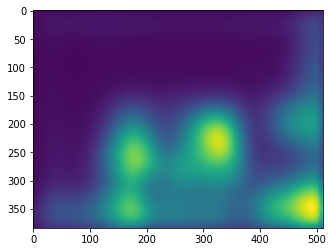

torch.Size([2, 384, 512, 1])


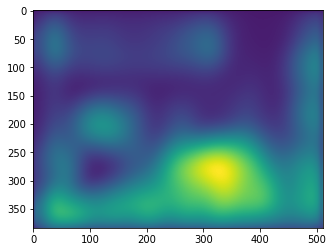

torch.Size([2, 384, 512, 1])


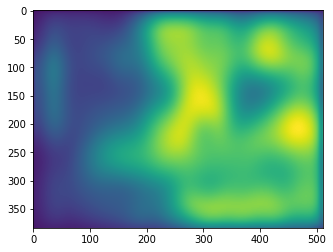

torch.Size([2, 384, 512, 1])


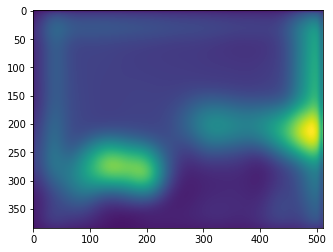

torch.Size([2, 384, 512, 1])


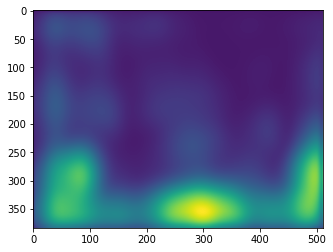

torch.Size([2, 384, 512, 1])


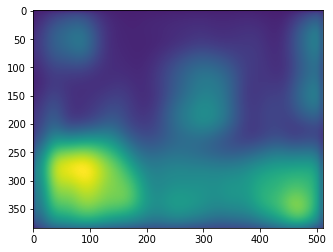

torch.Size([2, 384, 512, 1])


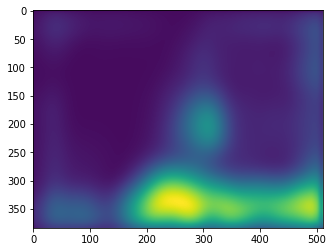

torch.Size([2, 384, 512, 1])


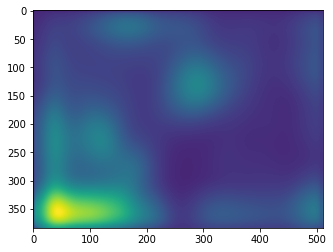

torch.Size([2, 384, 512, 1])


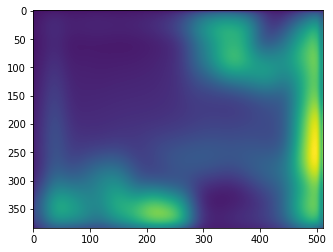

torch.Size([2, 384, 512, 1])


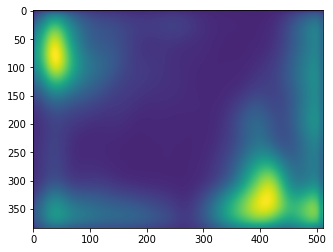

torch.Size([2, 384, 512, 1])


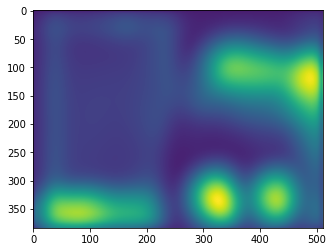

torch.Size([2, 384, 512, 1])


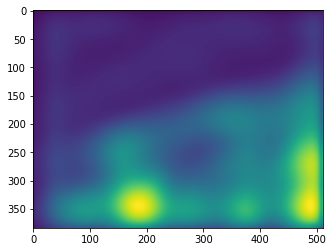

torch.Size([2, 384, 512, 1])


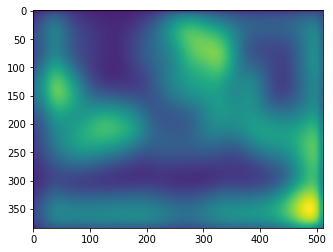

torch.Size([2, 384, 512, 1])


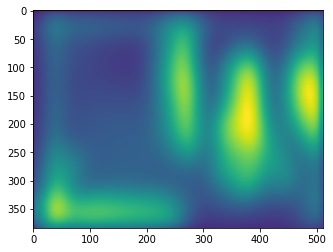

torch.Size([2, 384, 512, 1])


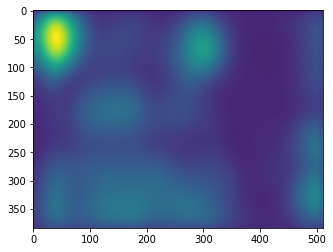

torch.Size([2, 384, 512, 1])


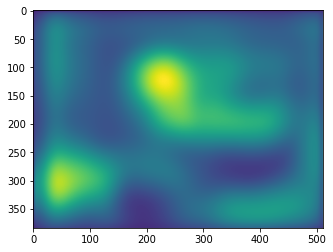

torch.Size([2, 384, 512, 1])


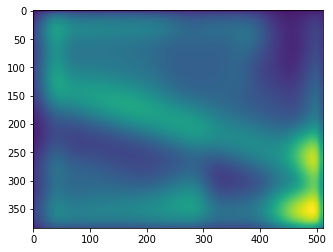

torch.Size([2, 384, 512, 1])


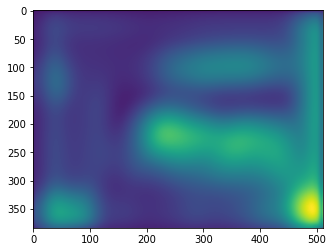

torch.Size([2, 384, 512, 1])


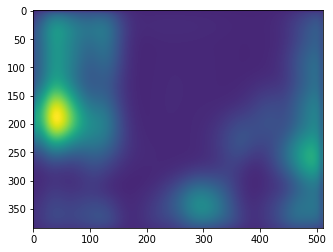

torch.Size([2, 384, 512, 1])


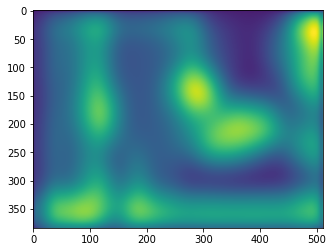

torch.Size([2, 384, 512, 1])


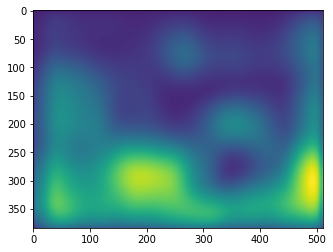

torch.Size([2, 384, 512, 1])


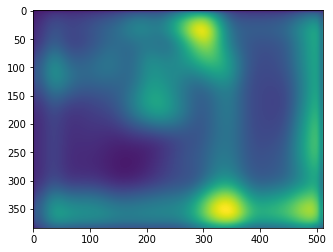

torch.Size([2, 384, 512, 1])


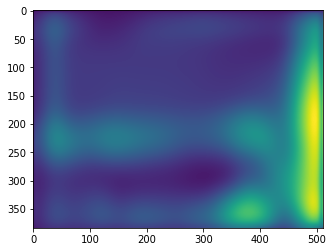

torch.Size([2, 384, 512, 1])


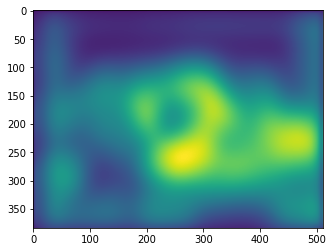

torch.Size([2, 384, 512, 1])


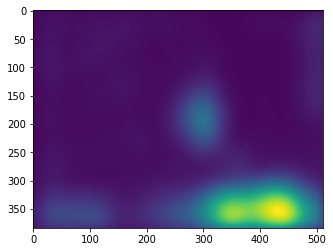

torch.Size([2, 384, 512, 1])


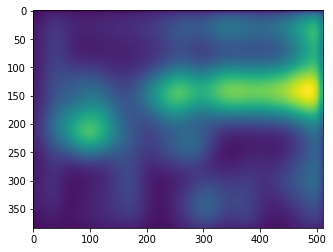

torch.Size([2, 384, 512, 1])


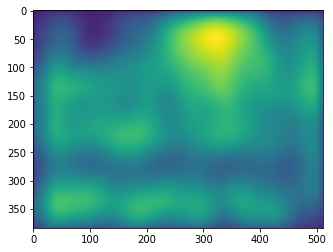

torch.Size([2, 384, 512, 1])


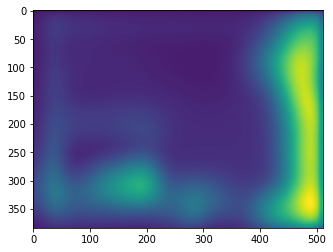

torch.Size([2, 384, 512, 1])


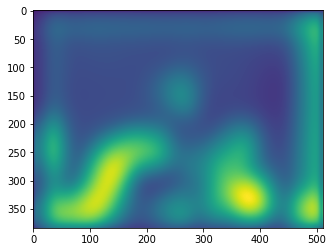

torch.Size([2, 384, 512, 1])


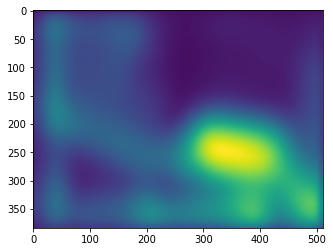

torch.Size([2, 384, 512, 1])


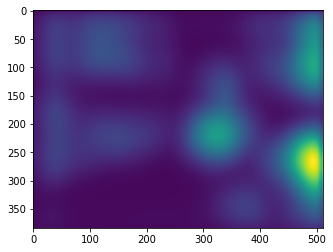

torch.Size([2, 384, 512, 1])


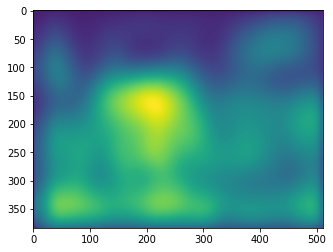

torch.Size([2, 384, 512, 1])


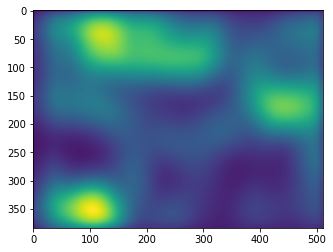

torch.Size([2, 384, 512, 1])


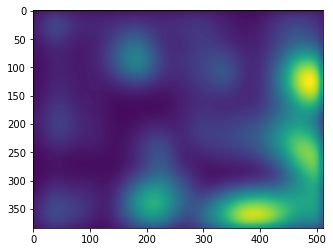

torch.Size([2, 384, 512, 1])


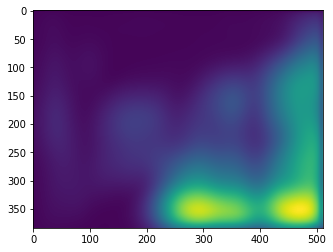

torch.Size([2, 384, 512, 1])


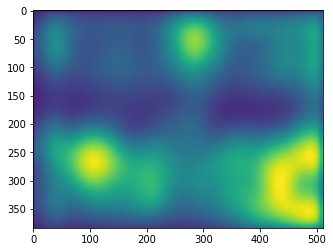

torch.Size([2, 384, 512, 1])


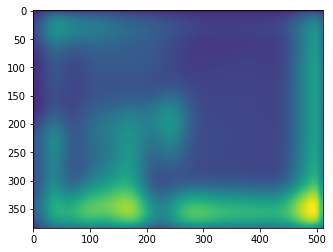

torch.Size([2, 384, 512, 1])


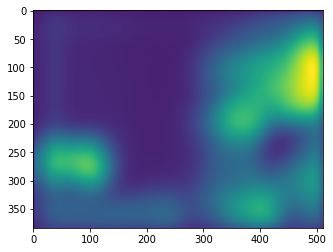

torch.Size([2, 384, 512, 1])


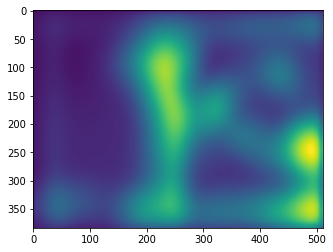

torch.Size([2, 384, 512, 1])


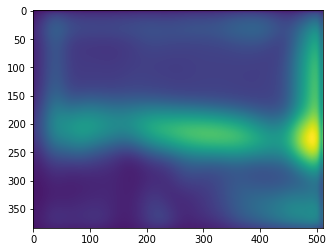

torch.Size([2, 384, 512, 1])


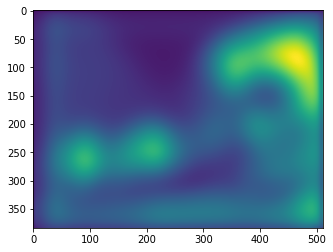

torch.Size([2, 384, 512, 1])


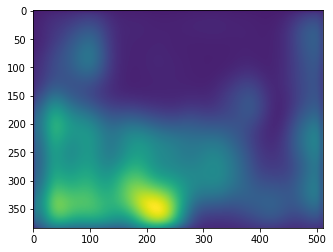

torch.Size([2, 384, 512, 1])


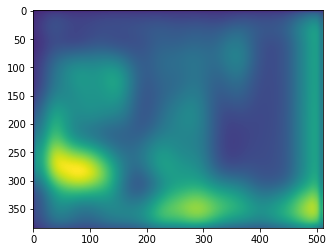

torch.Size([2, 384, 512, 1])


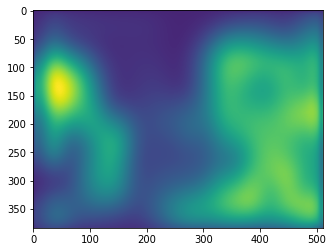

torch.Size([2, 384, 512, 1])


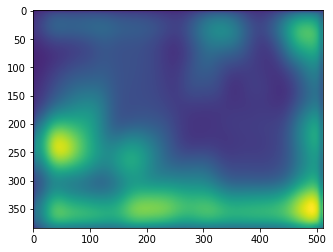

torch.Size([2, 384, 512, 1])


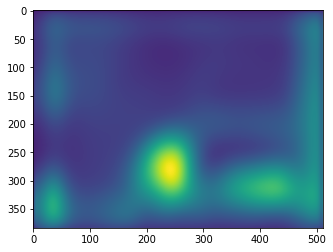

torch.Size([2, 384, 512, 1])


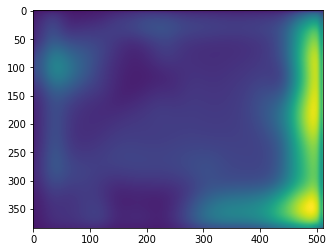

torch.Size([2, 384, 512, 1])


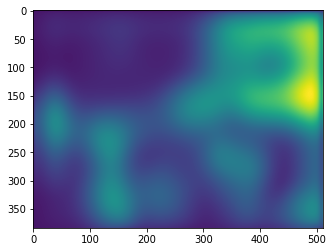

torch.Size([2, 384, 512, 1])


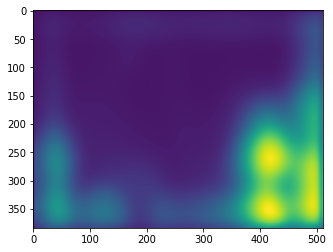

torch.Size([2, 384, 512, 1])


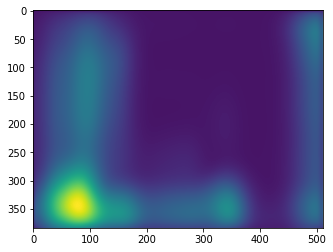

In [ ]:
# Checking if CUDA is good to go
torch.cuda.empty_cache()
device = None
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    raise Exception("WARNING: Could not find GPU! Using CPU only. \
To enable GPU, please to go Edit > Notebook Settings > Hardware \
Accelerator and select GPU.")

# Can change this for your local machine
high_level_path = "/content/drive/Shareddrives/DIODE Data"
train_diode = DIODE("diode_meta.json", high_level_path, ('train'), ('indoors', 'outdoor'))
val_diode = DIODE("diode_meta.json", high_level_path, ('val'), ('indoors'))
print(len(val_diode))
# Fixing the sizes for the train, validation, and test data
# NOTE: These must add up to length of the data sets when splitting below
train_size = 100
val_size = 10
test_size = 5

# Splitting up the data into smaller subsets
# The generator for selecting a random dataset is currently fixed just to be reproducible.
train_data, val_data, test_data, _ = torch.utils.data.random_split(val_diode, [train_size, val_size, test_size, 105], generator=torch.Generator().manual_seed(3))
# things to be done to the data 
    # permute rgb images to shape (3, 768, 1024)
    # train/val ground truth depth needs to be downsampled and set to 350 / img and clipped between range
    # 

train_dl = DataLoader(train_data, batch_size=2)
val_dl = DataLoader(val_data, batch_size=2)
test_dl = DataLoader(test_data, batch_size=2)
# list        RGB batch        depth batch  depth mask batch
# batch: [(8, 768, 1024, 3), (8, 768, 1024), (8, 768, 1024)]
# for i, batch in enumerate(train_dl):
#   plt.imshow(np.transpose(batch[0][0], (1, 2, 0)))
#   plt.show()

densemodel = Dense().to(device)
#net = Dense().to(device)

learning_rate = 1e-4
weight_decay = 0.0
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densemodel.parameters(), learning_rate, weight_decay=weight_decay, betas=[0.9, 0.999])
num_epoch = 10

for i in range(num_epoch):
        training_loss = train(train_dl, densemodel, criterion, optimizer, device, i)
        val_loss = test(val_dl, densemodel, criterion, device, num_epoch, i)
        print('Validation loss: ', val_loss)
        if i%10 == 0:
          ap = eval(test_dl, densemodel, device)
          print('mAP: ', np.round(ap*100,3), '%')

with torch.no_grad():
    for i, image in enumerate(train_dl):
        images = (image[0].type(torch.float)).to(device)
        output = densemodel(images)
        output = output.permute(0, 2, 3, 1)
        print(output.size())
        plt.imshow(output[0][:,:,0].cpu())
        plt.show()
        